# I’m Something of a Painter Myself - Use GANs to create art - will you be the next Monet?

### Jakub Kucera (kucerj56)

In [1]:
import os
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# This is done to disable some error/exception when being run on Windows using Conda
os.environ['KMP_DUPLICATE_LIB_OK'] = "True"

In [3]:
torch.cuda.is_available()

True

In [4]:
if torch.backends.mps.is_available():
    # Apple ARM GPU
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


In [5]:
# MONET_DATA_PATH = "./data-monet/monet/"
MONET_DATA_PATH = os.path.join('.', 'data-monet', 'monet')
# ORIG_DATA_PATH = "./data-monet/photo/"
ORIG_DATA_PATH = os.path.join('.', 'data-monet', 'photo')
BATCH_SIZE = 1
IMG_SIZE = 256
IMG_PIXEL_COUNT = IMG_SIZE * IMG_SIZE * 3
# EPOCH_COUNT = 5 # for testing changes
EPOCH_COUNT = 200  # for final run only
RESNET_BLOCK_COUNT = 9
GAN_TRAINING_WEIGHT = 10
OPTIMIZER_ADAM_BETAS = (0.5, 0.99)

In [6]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

monet_dataset = ImageFolder(root=MONET_DATA_PATH, transform=transform)

photo_dataset = ImageFolder(root=ORIG_DATA_PATH, transform=transform)

In [7]:
monet_dataloader = torch.utils.data.DataLoader(monet_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
photo_dataloader = torch.utils.data.DataLoader(photo_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [8]:
arr = next(iter(monet_dataloader))[0][0].numpy().transpose((1, 2, 0))

In [9]:
print(arr)

[[[ 0.9529412   0.9529412   0.9372549 ]
  [ 0.9372549   0.9372549   0.92156863]
  [ 0.9137255   0.9137255   0.8980392 ]
  ...
  [ 0.3411765   0.2313726   0.16078436]
  [ 0.32549024  0.21568632  0.14509809]
  [ 0.22352946  0.11372554  0.04313731]]

 [[ 0.94509804  0.94509804  0.92941177]
  [ 0.92941177  0.92941177  0.9137255 ]
  [ 0.9137255   0.9137255   0.8980392 ]
  ...
  [ 0.33333337  0.22352946  0.15294123]
  [ 0.35686278  0.24705887  0.17647064]
  [ 0.28627455  0.17647064  0.10588241]]

 [[ 0.9372549   0.9372549   0.92156863]
  [ 0.92156863  0.92156863  0.90588236]
  [ 0.90588236  0.90588236  0.8901961 ]
  ...
  [ 0.3411765   0.2313726   0.14509809]
  [ 0.35686278  0.24705887  0.16078436]
  [ 0.27843142  0.1686275   0.082353  ]]

 ...

 [[-0.19999999 -0.5058824  -0.56078434]
  [-0.24705881 -0.5372549  -0.58431375]
  [-0.36470586 -0.62352943 -0.6784314 ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [

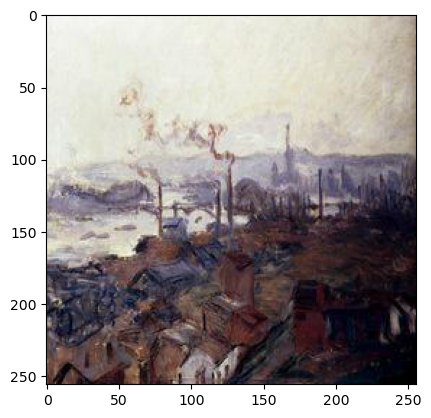

In [10]:
plt.imshow(arr * 0.5 + 0.5)

In [11]:
class ResBlock(nn.Module):
    def __init__(self, features):
        super(ResBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(features, features, 3),
            nn.InstanceNorm2d(features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(features, features, 3),
            nn.InstanceNorm2d(features)
        )

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(self, res_blocks: int):
        inner_channels=64
        super(Generator, self).__init__()
        # downscaling
        # for i in range(0, 3):
        #     layers.extend([
        #         nn.Conv2d(in_channels=gen_input_dim*(2**i), out_channels=f*(2**i), kernel_size=(3,3), stride=(1,1)),
        #         nn.InstanceNorm2d(f*(2**i)),
        #         nn.ReLU(inplace=True)
        #     ])

        layers = [nn.ReflectionPad2d(3),
                  nn.Conv2d(3, inner_channels, 7, 1, 0), nn.InstanceNorm2d(inner_channels), nn.ReLU(True),
                  nn.Conv2d(inner_channels, 2*inner_channels, 3, 2, 1), nn.InstanceNorm2d(2*inner_channels), nn.ReLU(True),
                  nn.Conv2d(2*inner_channels, 4*inner_channels, 3, 2, 1), nn.InstanceNorm2d(4*inner_channels), nn.ReLU(True)]
        for _ in range(res_blocks):
            layers.append(ResBlock(4*inner_channels))

        # upscaling
        # for i in range(3, 5, -1):
        #     layers.extend([
        #         nn.ConvTranspose2d(in_channels=gen_input_dim*(2**i), out_channels=f*(2**i), kernel_size=(3,3), stride=(1,1)),
        #         # layers += nn.PixelShuffle(2)  # TODO uncomment
        #         nn.InstanceNorm2d(f*(2**i)),
        #         nn.ReLU(inplace=True)
        #     ])
        # layers.extend([
        #     nn.ReflectionPad2d(3),
        #     nn.Conv2d(inner_channels, 3, 7, 1, 0),
        #     nn.Tanh()
        #  ])

        layers.extend([
                nn.ConvTranspose2d(4*inner_channels, 8*inner_channels, 3, 1, 1), nn.PixelShuffle(2), nn.InstanceNorm2d(2*inner_channels), nn.ReLU(True),
                nn.ConvTranspose2d(2*inner_channels,   4*inner_channels, 3, 1, 1), nn.PixelShuffle(2), nn.InstanceNorm2d(inner_channels), nn.ReLU(True),
                nn.ReflectionPad2d(3), nn.Conv2d(inner_channels, 3, 7, 1, 0),
                nn.Tanh()])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)

In [12]:
class Discriminator(nn.Module):
    def __init__(self, input_channel_count: int):
        super(Discriminator, self).__init__()

        # def discriminator_block(in_channels, out_channels, normalize=True):
        #     layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
        #     if normalize:
        #         layers.append(nn.InstanceNorm2d(out_channels))
        #     layers.append(nn.LeakyReLU(0.2, inplace=True))
        #     return layers

        # # TODO for loop and parametrize
        channel_counts = [input_channel_count, 64, 128, 256, 512]
        layers = []
        for i in range(len(channel_counts)-1):
            in_channels = channel_counts[i]
            out_channels = channel_counts[i+1]
            layers.extend([
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            ])
        # layers = [
        #     *discriminator_block(input_channel_count, 64, normalize=False),
        #     *discriminator_block(64, 128),
        #     *discriminator_block(128,256),
        #     *discriminator_block(256,512),
        # ]
        layers.extend([
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512, 1, 4, padding=1)
        ])
        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [13]:
# # TODO sort out dimensions
# create instance of generators and discriminators for both domains
# (p - regular Photo)
# (m - Monet painting)
generator_p2m = Generator(res_blocks=RESNET_BLOCK_COUNT).to(device)
generator_m2p = Generator(res_blocks=RESNET_BLOCK_COUNT).to(device)
discriminator_p = Discriminator(input_channel_count=3).to(device)
discriminator_m = Discriminator(input_channel_count=3).to(device)

In [14]:
# USING MSE instead of original BCE, becuase that on does not require normalization to [0,1] and it does not throw exception
# TODO check what criterions are used in orig paper

criterion_disc_p = nn.MSELoss().to(device)
criterion_disc_m = nn.MSELoss().to(device)
indetity_criterion = torch.nn.L1Loss().to(device)
cycle_criterion = torch.nn.L1Loss().to(device)

optimizer_gen_p2m = optim.Adam(generator_p2m.parameters(), lr = 0.0002, betas=OPTIMIZER_ADAM_BETAS)
optimizer_gen_m2p = optim.Adam(generator_m2p.parameters(), lr = 0.0002, betas=OPTIMIZER_ADAM_BETAS)
optimizer_disc_p = optim.Adam(discriminator_p.parameters(), lr = 0.0002, betas=OPTIMIZER_ADAM_BETAS)
optimizer_disc_m = optim.Adam(discriminator_m.parameters(), lr = 0.0002, betas=OPTIMIZER_ADAM_BETAS)

In [15]:
# for the 1st 100 Epochs LR(learning rate) = 0.002, after that gradually reduce. On 200th epoch gets to 0

EPOCH_DECAY_START = 100
EPOCH_DECAY_END = 200
DEFAULT_LR = 0.0002
DECAY_STEP = DEFAULT_LR / (EPOCH_DECAY_END - EPOCH_DECAY_START)

def custom_lr(epoch_num):
    # TODO refactor
    if epoch_num <= EPOCH_DECAY_START:
        return DEFAULT_LR
    return DEFAULT_LR - DECAY_STEP * (epoch_num - EPOCH_DECAY_START)

# lr_scheduler_gen = LambdaLR(optimizer_gen, lr_lambda=[custom_lr])
lr_scheduler_gen_m2p = LambdaLR(optimizer_gen_m2p, lr_lambda=[custom_lr])
lr_scheduler_gen_p2m = LambdaLR(optimizer_gen_p2m, lr_lambda=[custom_lr])
lr_scheduler_disc_p = LambdaLR(optimizer_disc_p, lr_lambda=[custom_lr])
lr_scheduler_disc_m = LambdaLR(optimizer_disc_m, lr_lambda=[custom_lr])

In [16]:
# def label_real(b_size = BATCH_SIZE):
    # data = torch.ones(b_size, 1)
def label_real(shape):
    data = torch.ones(shape)
    return data.to(device)

# def label_fake(b_size = BATCH_SIZE):
    # data = torch.zeros(b_size, 1)
def label_fake(shape):
    data = torch.zeros(shape)
    return data.to(device)

In [17]:
def train_discriminator(data_real, data_fake, discriminator, optimizer, criterion):
    optimizer.zero_grad()
    # discriminator.train()  # TODO uncomment? - TODO find out more

    output_real = discriminator(data_real)
    loss_real = criterion(output_real, label_real(output_real.shape))

    output_fake = discriminator(data_fake.detach())
    loss_fake = criterion(output_fake, label_fake(output_fake.shape))

    # TODO try DEL this and instead call backwards twice. Like 5th lab
    loss = (loss_real + loss_fake) / 2

    loss.backward()
    # loss_real.backward()
    # loss_fake.backward()
    optimizer.step()

    # return loss_real + loss_fake
    return loss


Epoch #1
Image #0
Image #1
Image #2
Image #3
Image #4
Image #5
Image #6
Image #7
Image #8
Image #9
Image #10
Image #11
Image #12
Image #13
Image #14
Image #15
Image #16
Image #17
Image #18
Image #19
Image #20
Image #21
Image #22
Image #23
Image #24
Image #25
Image #26
Image #27
Image #28
Image #29
Image #30
Image #31
Image #32
Image #33
Image #34
Image #35
Image #36
Image #37
Image #38
Image #39
Image #40
Image #41
Image #42
Image #43
Image #44
Image #45
Image #46
Image #47
Image #48
Image #49
Image #50
Image #51
Image #52
Image #53
Image #54
Image #55
Image #56
Image #57
Image #58
Image #59
Image #60
Image #61
Image #62
Image #63
Image #64
Image #65
Image #66
Image #67
Image #68
Image #69
Image #70
Image #71
Image #72
Image #73
Image #74
Image #75
Image #76
Image #77
Image #78
Image #79
Image #80
Image #81
Image #82
Image #83
Image #84
Image #85
Image #86
Image #87
Image #88
Image #89
Image #90
Image #91
Image #92
Image #93
Image #94
Image #95
Image #96
Image #97
Image #98
Image #99
I

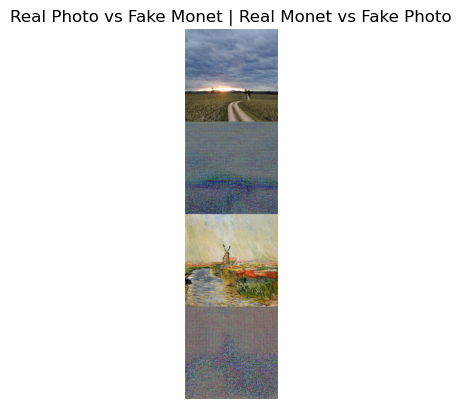

Epoch Training took 0:02:08.723404
Epoch #2
Image #0
Image #1
Image #2
Image #3
Image #4
Image #5
Image #6
Image #7
Image #8
Image #9
Image #10
Image #11
Image #12
Image #13
Image #14
Image #15
Image #16
Image #17
Image #18
Image #19
Image #20
Image #21
Image #22
Image #23
Image #24
Image #25
Image #26
Image #27
Image #28
Image #29
Image #30
Image #31
Image #32
Image #33
Image #34
Image #35
Image #36
Image #37
Image #38
Image #39
Image #40
Image #41
Image #42
Image #43
Image #44
Image #45
Image #46
Image #47
Image #48
Image #49
Image #50
Image #51
Image #52
Image #53
Image #54
Image #55
Image #56
Image #57
Image #58
Image #59
Image #60
Image #61
Image #62
Image #63
Image #64
Image #65
Image #66
Image #67
Image #68
Image #69
Image #70
Image #71
Image #72
Image #73
Image #74
Image #75
Image #76
Image #77
Image #78
Image #79
Image #80
Image #81
Image #82
Image #83
Image #84
Image #85
Image #86
Image #87
Image #88
Image #89
Image #90
Image #91
Image #92
Image #93
Image #94
Image #95
Image 

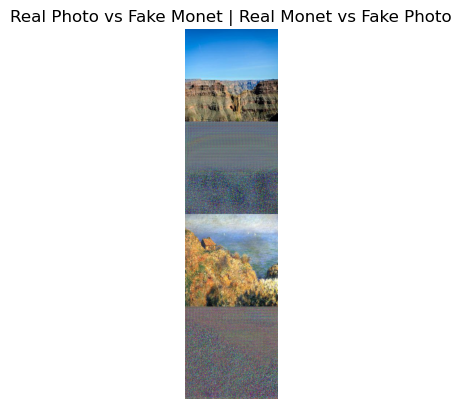

Epoch Training took 0:02:09.365053
Epoch #3
Image #0
Image #1
Image #2
Image #3
Image #4
Image #5
Image #6
Image #7
Image #8
Image #9
Image #10
Image #11
Image #12
Image #13
Image #14
Image #15
Image #16
Image #17
Image #18
Image #19
Image #20
Image #21
Image #22
Image #23
Image #24
Image #25
Image #26
Image #27
Image #28
Image #29
Image #30
Image #31
Image #32
Image #33
Image #34
Image #35
Image #36
Image #37
Image #38
Image #39
Image #40
Image #41
Image #42
Image #43
Image #44
Image #45
Image #46
Image #47
Image #48
Image #49
Image #50
Image #51
Image #52
Image #53
Image #54
Image #55
Image #56
Image #57
Image #58
Image #59
Image #60
Image #61
Image #62
Image #63
Image #64
Image #65
Image #66
Image #67
Image #68
Image #69
Image #70
Image #71
Image #72
Image #73
Image #74
Image #75
Image #76
Image #77
Image #78
Image #79
Image #80
Image #81
Image #82
Image #83
Image #84
Image #85
Image #86
Image #87
Image #88
Image #89
Image #90
Image #91
Image #92
Image #93
Image #94
Image #95
Image 

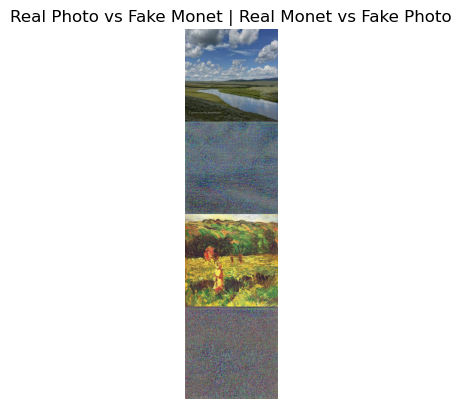

Epoch Training took 0:02:10.347052
Epoch #4
Image #0
Image #1
Image #2
Image #3
Image #4
Image #5
Image #6
Image #7
Image #8
Image #9
Image #10
Image #11
Image #12
Image #13
Image #14
Image #15
Image #16
Image #17
Image #18
Image #19
Image #20
Image #21
Image #22
Image #23
Image #24
Image #25
Image #26
Image #27
Image #28
Image #29
Image #30
Image #31
Image #32
Image #33
Image #34
Image #35
Image #36
Image #37
Image #38
Image #39
Image #40
Image #41
Image #42
Image #43
Image #44
Image #45
Image #46
Image #47
Image #48
Image #49
Image #50
Image #51
Image #52
Image #53
Image #54
Image #55
Image #56
Image #57
Image #58
Image #59
Image #60
Image #61
Image #62
Image #63
Image #64
Image #65
Image #66
Image #67
Image #68
Image #69
Image #70
Image #71
Image #72
Image #73
Image #74
Image #75
Image #76
Image #77
Image #78
Image #79
Image #80
Image #81
Image #82
Image #83
Image #84
Image #85
Image #86
Image #87
Image #88
Image #89
Image #90
Image #91
Image #92
Image #93
Image #94
Image #95
Image 

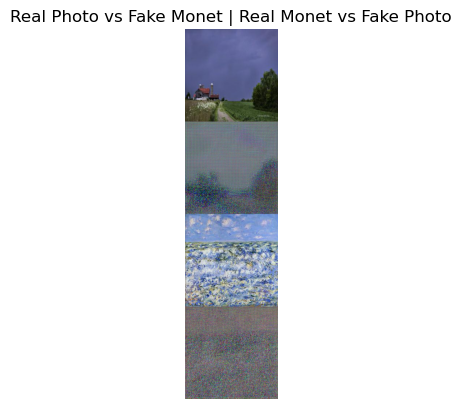

Epoch Training took 0:02:10.213055
Epoch #5
Image #0
Image #1
Image #2
Image #3
Image #4
Image #5
Image #6
Image #7
Image #8
Image #9
Image #10
Image #11
Image #12
Image #13
Image #14
Image #15
Image #16
Image #17
Image #18
Image #19
Image #20
Image #21
Image #22
Image #23
Image #24
Image #25
Image #26
Image #27
Image #28
Image #29
Image #30
Image #31
Image #32
Image #33
Image #34
Image #35
Image #36
Image #37
Image #38
Image #39
Image #40
Image #41
Image #42
Image #43
Image #44
Image #45
Image #46
Image #47
Image #48
Image #49
Image #50
Image #51
Image #52
Image #53
Image #54
Image #55
Image #56
Image #57
Image #58
Image #59
Image #60
Image #61
Image #62
Image #63
Image #64
Image #65
Image #66
Image #67
Image #68
Image #69
Image #70
Image #71
Image #72
Image #73
Image #74
Image #75
Image #76
Image #77
Image #78
Image #79
Image #80
Image #81
Image #82
Image #83
Image #84
Image #85
Image #86
Image #87
Image #88
Image #89
Image #90
Image #91
Image #92
Image #93
Image #94
Image #95
Image 

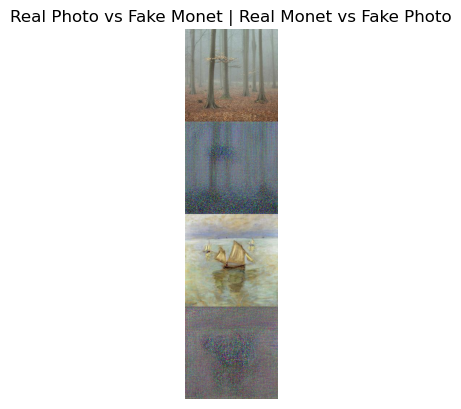

Epoch Training took 0:02:10.527057
Epoch #6
Image #0
Image #1
Image #2
Image #3
Image #4
Image #5
Image #6
Image #7
Image #8
Image #9
Image #10
Image #11
Image #12
Image #13
Image #14
Image #15
Image #16
Image #17
Image #18
Image #19
Image #20
Image #21
Image #22
Image #23
Image #24
Image #25
Image #26
Image #27
Image #28
Image #29
Image #30
Image #31
Image #32
Image #33
Image #34
Image #35
Image #36
Image #37
Image #38
Image #39
Image #40
Image #41
Image #42
Image #43
Image #44
Image #45
Image #46
Image #47
Image #48
Image #49
Image #50
Image #51
Image #52
Image #53
Image #54
Image #55
Image #56
Image #57
Image #58
Image #59
Image #60
Image #61
Image #62
Image #63
Image #64
Image #65
Image #66
Image #67
Image #68
Image #69
Image #70
Image #71
Image #72
Image #73
Image #74
Image #75
Image #76
Image #77
Image #78
Image #79
Image #80
Image #81
Image #82
Image #83
Image #84
Image #85
Image #86
Image #87
Image #88
Image #89
Image #90
Image #91
Image #92
Image #93
Image #94
Image #95
Image 

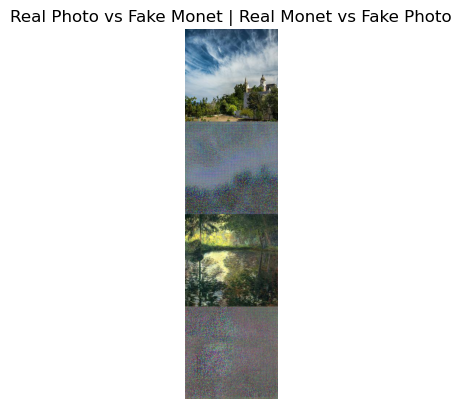

Epoch Training took 0:02:10.605499
Epoch #7
Image #0
Image #1
Image #2
Image #3
Image #4
Image #5
Image #6
Image #7
Image #8
Image #9
Image #10
Image #11
Image #12
Image #13
Image #14
Image #15
Image #16
Image #17
Image #18
Image #19
Image #20
Image #21
Image #22
Image #23
Image #24
Image #25
Image #26
Image #27
Image #28
Image #29
Image #30
Image #31
Image #32
Image #33
Image #34
Image #35
Image #36
Image #37
Image #38
Image #39
Image #40
Image #41
Image #42
Image #43
Image #44
Image #45
Image #46
Image #47
Image #48
Image #49
Image #50
Image #51
Image #52
Image #53
Image #54
Image #55
Image #56
Image #57
Image #58
Image #59
Image #60
Image #61
Image #62
Image #63
Image #64
Image #65
Image #66
Image #67
Image #68
Image #69
Image #70
Image #71
Image #72
Image #73
Image #74
Image #75
Image #76
Image #77
Image #78
Image #79
Image #80
Image #81
Image #82
Image #83
Image #84
Image #85
Image #86
Image #87
Image #88
Image #89
Image #90
Image #91
Image #92
Image #93
Image #94
Image #95
Image 

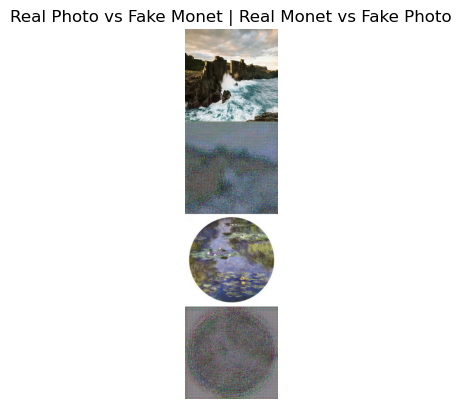

Epoch Training took 0:02:10.365053
Epoch #8
Image #0
Image #1
Image #2
Image #3
Image #4
Image #5
Image #6
Image #7
Image #8
Image #9
Image #10
Image #11
Image #12
Image #13
Image #14
Image #15
Image #16
Image #17
Image #18
Image #19
Image #20
Image #21
Image #22
Image #23
Image #24
Image #25
Image #26
Image #27
Image #28
Image #29
Image #30
Image #31
Image #32
Image #33
Image #34
Image #35
Image #36
Image #37
Image #38
Image #39
Image #40
Image #41
Image #42
Image #43
Image #44
Image #45
Image #46
Image #47
Image #48
Image #49
Image #50
Image #51
Image #52
Image #53
Image #54
Image #55
Image #56
Image #57
Image #58
Image #59
Image #60
Image #61
Image #62
Image #63
Image #64
Image #65
Image #66
Image #67
Image #68
Image #69
Image #70
Image #71
Image #72
Image #73
Image #74
Image #75
Image #76
Image #77
Image #78
Image #79
Image #80
Image #81
Image #82
Image #83
Image #84
Image #85
Image #86
Image #87
Image #88
Image #89
Image #90
Image #91
Image #92
Image #93
Image #94
Image #95
Image 

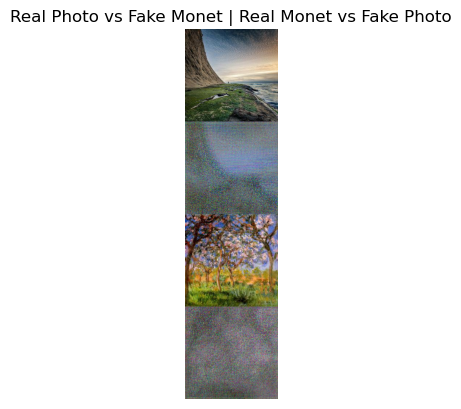

Epoch Training took 0:02:10.290057
Epoch #9
Image #0
Image #1
Image #2
Image #3
Image #4
Image #5
Image #6
Image #7
Image #8
Image #9
Image #10
Image #11
Image #12
Image #13
Image #14
Image #15
Image #16
Image #17
Image #18
Image #19
Image #20
Image #21
Image #22
Image #23
Image #24
Image #25
Image #26
Image #27
Image #28
Image #29
Image #30
Image #31
Image #32
Image #33
Image #34
Image #35
Image #36
Image #37
Image #38
Image #39
Image #40
Image #41
Image #42
Image #43
Image #44
Image #45
Image #46
Image #47
Image #48
Image #49
Image #50
Image #51
Image #52
Image #53
Image #54
Image #55
Image #56
Image #57
Image #58
Image #59
Image #60
Image #61
Image #62
Image #63
Image #64
Image #65
Image #66
Image #67
Image #68
Image #69
Image #70
Image #71
Image #72
Image #73
Image #74
Image #75
Image #76
Image #77
Image #78
Image #79
Image #80
Image #81
Image #82
Image #83
Image #84
Image #85
Image #86
Image #87
Image #88
Image #89
Image #90
Image #91
Image #92
Image #93
Image #94
Image #95
Image 

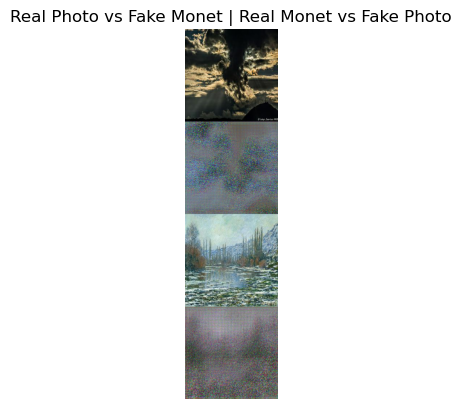

Epoch Training took 0:02:10.758057
Epoch #10
Image #0
Image #1
Image #2
Image #3
Image #4
Image #5
Image #6
Image #7
Image #8
Image #9
Image #10
Image #11
Image #12
Image #13
Image #14
Image #15
Image #16
Image #17
Image #18
Image #19
Image #20
Image #21
Image #22
Image #23
Image #24
Image #25
Image #26
Image #27


KeyboardInterrupt: 

In [18]:
# TODO swap some operations here? Put train_gen in function, so that it can be done easily. If not 1 function (needs to have both generators(cycle), then 3 functinos: cycle, gan, identity)


start = datetime.now()

# gen identity
all_epoch_loss_id_photo = []
all_epoch_loss_id_monet = []
# gen GAN
all_epoch_loss_gen_p2m = []
all_epoch_loss_gen_m2p = []
# gen cycle
all_epoch_loss_cycle = []
# discriminators
all_epoch_loss_disc_photo = []
all_epoch_loss_disc_monet = []

for epoch in range(1, EPOCH_COUNT+1):

    print(f"Epoch #{epoch}")
    epoch_start = datetime.now()

    # loss_g_p = 0.0
    # loss_g_m = 0.0
    # loss_g = 0.0

    # gen identity
    epoch_loss_id_photo = 0.0
    epoch_loss_id_monet = 0.0
    # gen GAN
    epoch_loss_gen_p2m = 0.0
    epoch_loss_gen_m2p = 0.0
    # gen cycle
    epoch_loss_cycle = 0.0
    # discriminators
    epoch_loss_disc_photo = 0.0
    epoch_loss_disc_monet = 0.0



    # TODO improve batch handeling
    #
    i = 0
    for (images_photo, photo_labels), (images_monet, monet_labels)  in zip(photo_dataloader, monet_dataloader):
        print(f"Image #{i}"); i += 1
        images_photo, photo_labels = images_photo[0].to(device), photo_labels.to(device)
        images_monet, monet_labels = images_monet.to(device), monet_labels.to(device)

        generator_p2m.train()
        generator_m2p.train()

        optimizer_gen_p2m.zero_grad()
        optimizer_gen_m2p.zero_grad()
        # optimizer_gen.zero_grad()

        # ========================================================

        # identity loss - optional part of cycle GANs
        loss_id_photo = indetity_criterion(generator_m2p(images_photo), images_photo)
        loss_id_monet = indetity_criterion(generator_p2m(images_monet), images_monet)
        # identity_loss = (loss_id_photo + loss_id_monet) / 2

        # ========================================================
        # classic GAN loss

        images_monet_fake = generator_p2m(images_photo)
        disc_m_out = discriminator_m(images_monet_fake)
        # even thought the images are fake, they are compared as real ones, since here we dont train the discriminator, but the generator
        loss_gen_p2m = criterion_disc_m(disc_m_out, label_real(disc_m_out.shape))

        images_photo_fake = generator_m2p(images_monet)
        disc_p_out = discriminator_p(images_photo_fake)
        loss_gen_m2p = criterion_disc_p(disc_p_out, label_real(disc_p_out.shape))
        # loss_gen_disc = (loss_gen_p2m_disc + loss_gen_m2p_disc) / 2

        # ========================================================
        # cycle loss

        images_photo_fake_cycle = generator_m2p(images_monet_fake)
        loss_cycle_p2m2p = cycle_criterion(images_photo, images_photo_fake_cycle)

        images_monet_fake_cycle = generator_p2m(images_photo_fake)
        loss_cycle_m2p2m = cycle_criterion(images_monet, images_monet_fake_cycle)

        loss_cycle = (loss_cycle_m2p2m + loss_cycle_p2m2p) / 2

        # ========================================================
        # total loss

        # total_loss = identity_loss + loss_gen_disc + loss_cycle
        # total_loss = 5*identity_loss + 10*loss_gen_disc + loss_cycle
        total_loss_monet = 0.5*GAN_TRAINING_WEIGHT*loss_id_monet + loss_gen_p2m + GAN_TRAINING_WEIGHT*loss_cycle
        total_loss_photo = 0.5*GAN_TRAINING_WEIGHT*loss_id_photo + loss_gen_m2p + GAN_TRAINING_WEIGHT*loss_cycle
        total_loss = (total_loss_monet + total_loss_photo) / 2
        total_loss.backward()

        # loss_g += total_loss

        # identity
        epoch_loss_id_photo += loss_id_photo
        epoch_loss_id_monet += loss_id_monet

        # gan
        epoch_loss_gen_p2m += loss_gen_p2m
        epoch_loss_gen_m2p += loss_gen_m2p

        # cycle
        epoch_loss_cycle += loss_cycle


        optimizer_gen_m2p.step()
        optimizer_gen_p2m.step()
        # optimizer_gen.step()

        # ========================================================
        # train discriminators

        #  this could be run multiple times to
        for step in range(1):
            epoch_loss_disc_photo += train_discriminator(data_real=images_photo, data_fake=images_photo_fake,
                                 discriminator=discriminator_p, optimizer=optimizer_disc_p,
                                 criterion=criterion_disc_p)

            epoch_loss_disc_monet += train_discriminator(data_real=images_monet, data_fake=images_monet_fake,
                                 discriminator=discriminator_m, optimizer=optimizer_disc_m,
                                 criterion=criterion_disc_m)

    # change the learning rate
    lr_scheduler_gen_p2m.step()
    lr_scheduler_gen_m2p.step()
    lr_scheduler_disc_p.step()
    lr_scheduler_disc_m.step()

    # logs the losses over time
    all_epoch_loss_id_photo.append(epoch_loss_id_photo.item())
    all_epoch_loss_id_monet.append(epoch_loss_id_monet.item())
    all_epoch_loss_gen_p2m.append(epoch_loss_gen_p2m.item())
    all_epoch_loss_gen_m2p.append(epoch_loss_gen_m2p.item())
    all_epoch_loss_cycle.append(epoch_loss_cycle.item())
    all_epoch_loss_disc_photo.append(epoch_loss_disc_photo.item())
    all_epoch_loss_disc_monet.append(epoch_loss_disc_monet.item())


    # TODO put into func?
    real_A = make_grid(images_photo, nrow=5, normalize=True)
    fake_B = make_grid(images_monet_fake, nrow=5, normalize=True)
    real_B = make_grid(images_monet, nrow=5, normalize=True)
    fake_A = make_grid(images_photo_fake, nrow=5, normalize=True)
    # Arange images along y-axis
    # image_grid_1 = torch.cat((real_A, fake_B), 0)
    # image_grid_2 = torch.cat((real_B, fake_A), 0)
    # image_grid = torch.cat((image_grid_1, image_grid_2), 1)
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    plt.imshow(image_grid.cpu().permute(1,2,0))
    plt.title('Real Photo vs Fake Monet | Real Monet vs Fake Photo')
    plt.axis('off')
    plt.show()

    epoch_end = datetime.now()
    print(f"Epoch Training took {epoch_end-epoch_start}")
    print(20*"=")

end = datetime.now()
print(f"Training took {end-start}")

In [ ]:
# images = next(iter(photo_dataloader))[0]
# # images.to(device)
# images_fake = generator_p2m(images).detach()
# for i in range(0, 15):
#     orig_img = images[i].numpy().transpose((1, 2, 0))
#     plt.imshow(arr)
#     plt.imshow(images_fake[i].view(256, 256, 3))


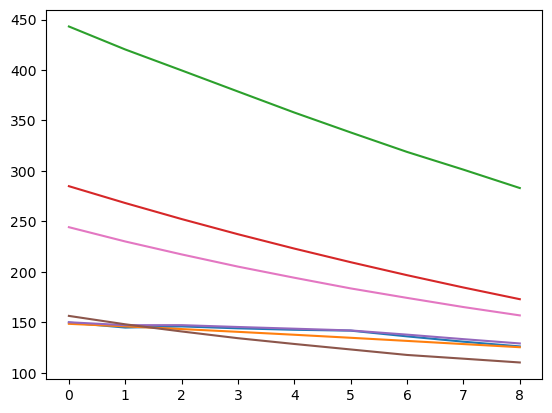

In [19]:
plt.plot(all_epoch_loss_id_photo)
plt.plot(all_epoch_loss_id_monet)
plt.plot(all_epoch_loss_gen_p2m)
plt.plot(all_epoch_loss_gen_m2p)
plt.plot(all_epoch_loss_cycle)
plt.plot(all_epoch_loss_disc_photo)
plt.plot(all_epoch_loss_disc_monet)


### Save models

In [ ]:
STORAGE_DIR = "models/"
PATH = STORAGE_DIR + "04/"
torch.save(generator_p2m, PATH + "generator_p2m.pt")
torch.save(generator_m2p, PATH + "generator_m2p.pt")
torch.save(discriminator_p, PATH + "discriminator_p.pt")
torch.save(discriminator_m, PATH + "discriminator_m.pt")


### Load models

In [ ]:
# generator_p2m = torch.load(PATH + "generator_p2m.pt")
# generator_m2p = torch.load(PATH + "generator_m2p.pt")
# discriminator_p = torch.load(PATH + "discriminator_p.pt")
# discriminator_m = torch.load(PATH + "discriminator_m.pt")

In [ ]:
# TODO prob create new `photo_dataloader` instance
for (images_photo, photo_labels)  in photo_dataloader:
        print(f"Image #{i}"); i += 1
        images_photo, photo_labels = images_photo[0].to(device), photo_labels.to(device)
        images_fake_monet = generator_p2m(images_photo)


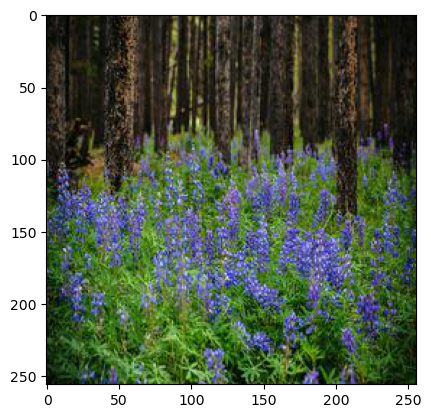

In [20]:
arr = images_photo.cpu().numpy().transpose((1, 2, 0))
plt.imshow(arr * 0.5 + 0.5)

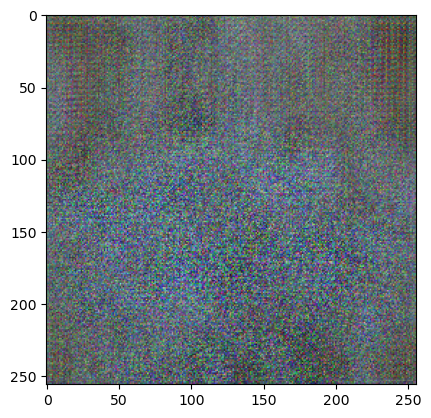

In [21]:
arr = images_monet_fake.detach().cpu().numpy().transpose((1, 2, 0))
plt.imshow(arr * 0.5 + 0.5)
# 